<a href="https://colab.research.google.com/github/PrzemyslawSarnacki/AirQualityPrediction/blob/master/cities_sts.ipynb" target="_parent">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a> 

## Wstępna obróbka danych

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
import numpy as np
import unicodedata
from io import BytesIO
import requests
import joblib


warnings.simplefilter('ignore')
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import tensorflow as tf
import tensorflow_probability as tfp

def strip_accents(text):
    return ''.join(c for c in unicodedata.normalize('NFKD', text.lower().replace("ł","l")) if unicodedata.category(c) != 'Mn')

CITIES = ["Warszawa", "Kraków", "Poznań", "Katowice", "Białystok"]
COORDINATES = {
    "warszawa": {
        "latitude": 52.2297,
        "longitude": 21.0122
    },
    "krakow": {
        "latitude": 50.0647,
        "longitude": 19.9450
    },
    "poznan": {
        "latitude": 52.4064,
        "longitude": 16.9252
    },
    "katowice": {
        "latitude": 50.2649,
        "longitude": 19.0238
    },
    "bialystok": {
        "latitude": 53.1325,
        "longitude": 23.1688
    },
}
PARAMETERS = ['pm25', 'pm10', 'no2', 'so2', 'o3', 'co']

indices = [""] + [f".{i}" for i in range(1, 6)]
data = {}

df = pd.read_csv("https://raw.githubusercontent.com/PrzemyslawSarnacki/AirQualityPrediction/master/data/airq_data_2.csv", index_col=0, parse_dates=True)

# load machine learning model for aqi prediction
m_link = 'https://github.com/PrzemyslawSarnacki/AirQualityPrediction/blob/master/data/aqi.joblib?raw=true'
m_file = BytesIO(requests.get(m_link).content)
aqi_model = joblib.load(m_file)

# fill columns with data
for city in CITIES:
    data[strip_accents(city)] = pd.DataFrame(df, columns=[f"{strip_accents(city)}{item}" for item in indices])
    data[strip_accents(city)] = data[strip_accents(city)].rename(columns=data[strip_accents(city)].iloc[0]).drop(data[strip_accents(city)].index[0])
    data[strip_accents(city)] = data[strip_accents(city)].astype(float).interpolate(method="linear")
    data[strip_accents(city)].index = pd.to_datetime(data[strip_accents(city)].index)
    data[strip_accents(city)]["aqi"] = aqi_model.predict(data[strip_accents(city)].fillna(0))


In [2]:
from datetime import timedelta

last_date = data[strip_accents(CITIES[-1])].index[-1]
last_date_str = last_date.strftime("%Y-%m-%d")

half_year_date = last_date + timedelta(days=173) 
half_year_date_str = half_year_date.strftime("%Y-%m-%d")
date_range = pd.date_range(start=last_date_str, end=half_year_date_str, freq='D')

# Definicja funkcji 

In [3]:
def create_s_features(data, city, date_range):
  data[city] = data[city].append(pd.DataFrame(index=date_range))
  # create columns with seasonal features
  data[city]['day_of_month'] = data[city].index.day
  data[city]['month'] = data[city].index.month
  data[city]['day_of_week'] = data[city].index.dayofweek
  data[city]['daysinmonth'] = data[city].index.daysinmonth
  return data

def create_external_regressor(data, city):
  external = data[city]['aqi'].copy()
  one_year_aqi = data[city]['aqi'].head(365).copy()
  # delete unexpected values
  one_year_aqi[66:68] = [60, 70]
  observed_years_num = len(data[city]) / 365
  remainder =  observed_years_num % 1
  integer = observed_years_num - remainder 
  for i in range(1, int(integer + 1)):
    external[365*(i-1):365*i] = one_year_aqi

  external[365*i::] = one_year_aqi[:(round(remainder*365))]
  return external

def split_data(data, last_date_str, city, external):
  # split data for training and test 
  threshold_date = pd.to_datetime(last_date_str)
  mask = data[city].index < threshold_date
  df_train = data[city][mask]
  df_test = data[city][~ mask]
  df_test['aqi'] = external[~mask]
  df_train["date"] = df_train.index
  return df_train, df_test

In [4]:
def create_model(data, df_train, df_test, city, external):
  # Local linear trend. 
  local_linear_trend = tfp.sts.LocalLinearTrend(
      observed_time_series=df_train['aqi'].astype(np.float32), 
      name='local_linear_trend',
  )

  # We need to pre-define the number of days in each month.
  num_days_per_month = np.array(
    [
      [31, 28, 31, 30, 30, 31, 31, 31, 30, 31, 30, 31],
      [31, 28, 31, 30, 30, 31, 31, 31, 30, 31, 30, 31],
      [31, 29, 31, 30, 30, 31, 31, 31, 30, 31, 30, 31] # year with leap day.
    ] 
  )  

  # Define month of year seasonal variable.
  month_of_year = tfp.sts.Seasonal(
    num_seasons=12,
    num_steps_per_season=num_days_per_month,
    name='month_of_year'
  )

  # Define day of week as seasonal variable.
  day_of_week = tfp.sts.Seasonal(
      num_seasons=7,
      num_steps_per_season=1,
      observed_time_series=df_train['aqi'].astype(np.float32), 
      name='day_of_week',
  )

  # Create cyclic variable for day of the month.
  design_matrix_day_of_month = tf.reshape(
      np.sin(2*np.pi*data[city]['day_of_month'] / data[city]['daysinmonth']).values.astype(np.float32), 
      (-1, 1)
  )

  # Define day of the month as an external regressor.
  # We do not encode it as seasonal as the number of steps is not uniform.
  day_of_month = tfp.sts.LinearRegression(
      design_matrix=design_matrix_day_of_month,
      name='day_of_month'
  )

  # Define external regressor component. 
  # We use the whole data set (df) as we expect to have these values in the future. 
  design_matrix_x_var = tf.reshape(external.astype(np.float32), (-1, 1))

  x_var = tfp.sts.LinearRegression(
      design_matrix=design_matrix_x_var,
      name='x_var'
  )

  model_components = [
      local_linear_trend, 
      month_of_year, 
      day_of_week, 
      day_of_month, 
      x_var,
  ]

  toy_model = tfp.sts.Sum(
      components=model_components, 
      observed_time_series=df_train['aqi'].astype(np.float32)
      )
  return toy_model

W tym momencie wygenerujemy prognozę Air Quality Index dla ostatnich 6 miesięcy roku 2020 

In [5]:
def predict(df_train, df_test, toy_model, variational_posteriors):
  num_days_per_month = np.array(
    [
      [31, 28, 31, 30, 30, 31, 31, 31, 30, 31, 30, 31],
      [31, 28, 31, 30, 30, 31, 31, 31, 30, 31, 30, 31],
      [31, 29, 31, 30, 30, 31, 31, 31, 30, 31, 30, 31] # year with leap day.
    ] 
  )  
  q_samples = variational_posteriors.sample(1000)
  num_parameters = len(toy_model.parameters)

  # Compute number of days in the last 6 months of 2020.
  forecast_window = num_days_per_month[-1][6:13].sum() - 9

  # Get forecast distribution.
  forecast_dist = tfp.sts.forecast(
      toy_model,
      observed_time_series=df_train['aqi'].astype(np.float32),
      parameter_samples=q_samples,
      num_steps_forecast=forecast_window.astype(np.int32)
  )
  # Sample and compute mean and std. 
  num_samples = 100

  forecast_mean, forecast_scale, forecast_samples = (
      forecast_dist.mean().numpy().flatten(),
      forecast_dist.stddev().numpy().flatten(),
      forecast_dist.sample(num_samples).numpy().flatten()
  )

  df_test['y_pred'] = forecast_mean
  df_test['y_pred_std'] = forecast_scale
  df_test['errors'] = df_test['aqi'] - df_test['y_pred']
  return df_test

In [6]:
def run_city_prediction(data, city):
  data = create_s_features(data, city, date_range)
  external = create_external_regressor(data, city)
  df_train, df_test = split_data(data, last_date_str, city, external)
  toy_model = create_model(data, df_train, df_test, city, external)
  variational_posteriors = tfp.sts.build_factored_surrogate_posterior(model=toy_model, seed=42)
  q_prior_samples = variational_posteriors.sample(1000)
  # Set optimizer.
  optimizer = tf.optimizers.Adam(learning_rate=0.1)

  # Using fit_surrogate_posterior to build and optimize 
  # the variational loss function.
  @tf.function(experimental_compile=True)
  def train():
      # Build the joint density. 
      num_variational_steps = int(200)
      target_log_prob_fn = toy_model.joint_log_prob(
          observed_time_series=df_train['aqi'].astype(np.float32)
      )
      
      elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
          target_log_prob_fn=target_log_prob_fn,
          surrogate_posterior=variational_posteriors,
          optimizer=optimizer,
          num_steps=num_variational_steps,
          seed=42
      )
      
      return elbo_loss_curve

  # Run optimization.
  elbo_loss_curve = train()
  df_test = predict(df_train, df_test, toy_model, variational_posteriors)
  return df_train, df_test

# Białystok


In [7]:
df_train, df_test = run_city_prediction(data, strip_accents(CITIES[-1]))

Instructions for updating:
Do not call `graph_parents`.
Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


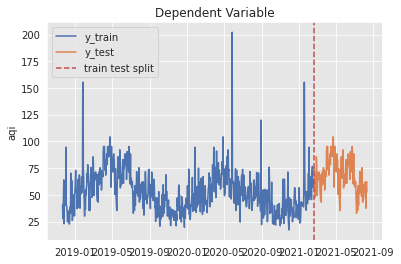

In [10]:
threshold_date = pd.to_datetime(last_date_str)
fig, ax = plt.subplots()

sns.lineplot(x=df_train.index, y='aqi', label='y_train', data=df_train, ax=ax)
sns.lineplot(x=df_test.index, y='aqi', label='y_test', data=df_test, ax=ax)
ax.axvline(threshold_date, color=sns_c[3], linestyle='--', label='train test split')
ax.legend(loc='upper left')
ax.set(title='Dependent Variable');

Przedstawmy wynik naszego modelu na wykresie

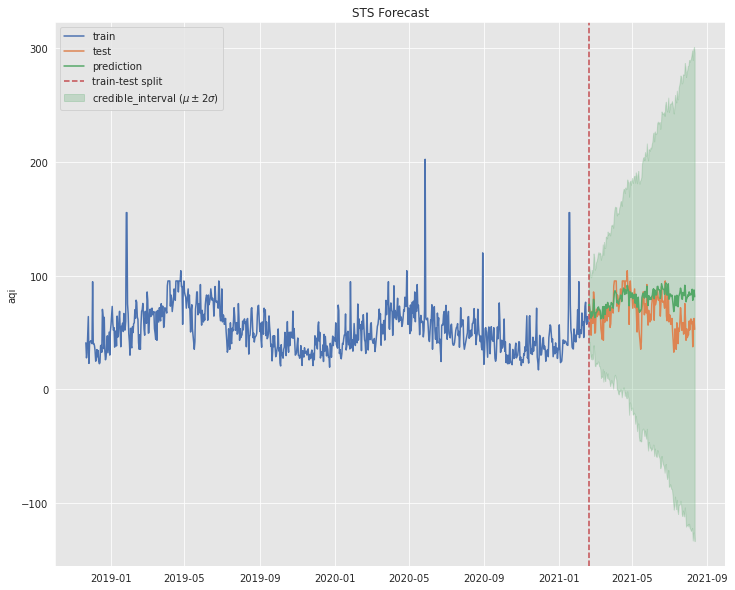

In [11]:
fig, ax = plt.subplots(figsize= (12, 10))

ax.fill_between(
    x=df_test.index,
    y1=df_test['y_pred']-2*df_test['y_pred_std'],
    y2=df_test['y_pred']+2*df_test['y_pred_std'],
    color=sns_c[2], 
    alpha=0.25,
    label=r'credible_interval ($\mu \pm 2\sigma$)'
)

sns.lineplot(x=df_train.index, y='aqi', label='train', data=df_train, ax=ax)
sns.lineplot(x=df_test.index, y='aqi', label='test', data=df_test, ax=ax)
sns.lineplot(x=df_test.index, y='y_pred', label='prediction', data=df_test, ax=ax)
ax.axvline(x= threshold_date, color=sns_c[3], linestyle='--', label='train-test split')
ax.legend(loc='upper left')
ax.set(title='STS Forecast');

Okres przewidywany z danymi rzeczywistymi w przybliżeniu 

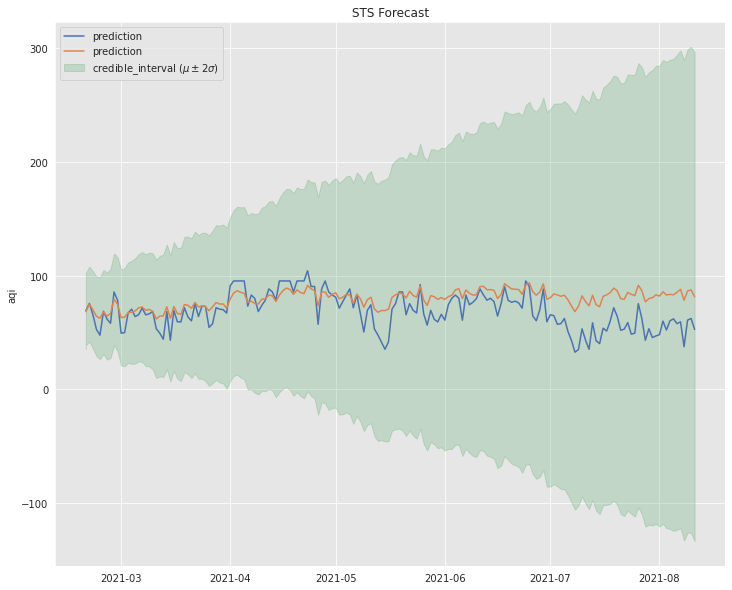

In [13]:
fig, ax = plt.subplots(figsize= (12, 10))

ax.fill_between(
    x=df_test.index,
    y1=df_test['y_pred']-2*df_test['y_pred_std'],
    y2=df_test['y_pred']+2*df_test['y_pred_std'],
    color=sns_c[2], 
    alpha=0.25,
    label=r'credible_interval ($\mu \pm 2\sigma$)'
)
sns.lineplot(x=df_test.index, y='aqi', label='prediction', data=df_test, ax=ax)
sns.lineplot(x=df_test.index, y='y_pred', label='prediction', data=df_test, ax=ax)
ax.legend(loc='upper left')
ax.set(title='STS Forecast');

Przedstawienie korelacji między predykcjami, a wartościami rzeczywistymi

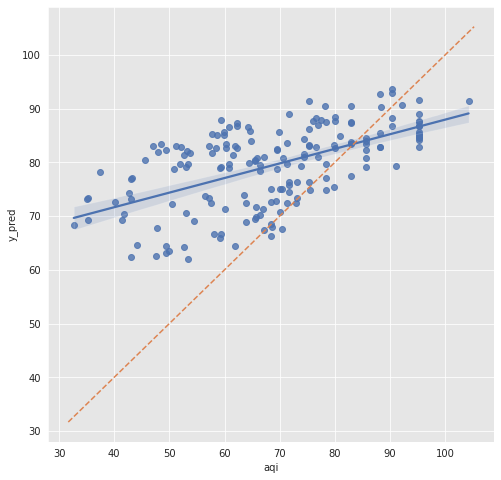

In [14]:
fig, ax = plt.subplots(figsize=(8,8))

# Generate diagonal line to plot. 
d_x = np.linspace(start=df_test['aqi'].min() - 1, stop=df_test['aqi'].max() + 1, num=100)
sns.regplot(x='aqi', y='y_pred', data=df_test, ax=ax)
sns.lineplot(x=d_x, y=d_x, dashes={'linestyle': ''}, ax=ax)
ax.lines[1].set_linestyle('--')

Sprawdźmy jak wyglądają poszczególne błędy modelu

Błąd średniokwadratowy (Mean Squared Error):

In [15]:
np.square(df_test["errors"]).mean()

288.41673287038606

Jak widzimy błędy mają postać rozkładu Rayleigha i większość błędów skupia się wokół wartości -40 

In [16]:
errors_mean = df_test['errors'].mean()
errors_std = df_test['errors'].std()


In [17]:
errors_mean

-11.01011262623589

[Text(0.5, 1.0, 'Model Errors (Test Set)')]

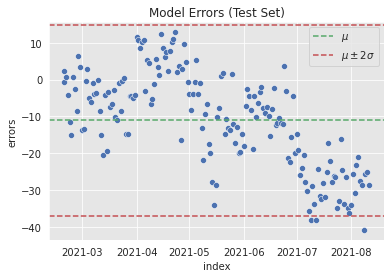

In [18]:
fig, ax = plt.subplots()

sns.scatterplot(x='index', y='errors', data=df_test.reset_index(), ax=ax)
ax.axhline(y=errors_mean, color=sns_c[2], linestyle='--', label=r'$\mu$ ')
ax.axhline(y=errors_mean + 2*errors_std, color=sns_c[3], linestyle='--', label=r'$\mu \pm 2\sigma$')
ax.axhline(y=errors_mean - 2*errors_std, color=sns_c[3], linestyle='--')
ax.legend()
ax.set(title='Model Errors (Test Set)')

# Warszawa

In [22]:
df_train, df_test = run_city_prediction(data, strip_accents(CITIES[0]))

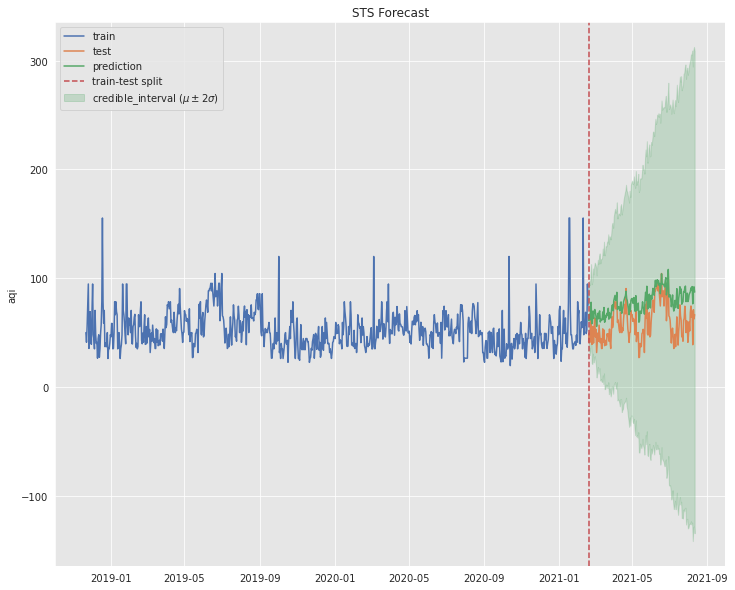

In [23]:
fig, ax = plt.subplots(figsize= (12, 10))

ax.fill_between(
    x=df_test.index,
    y1=df_test['y_pred']-2*df_test['y_pred_std'],
    y2=df_test['y_pred']+2*df_test['y_pred_std'],
    color=sns_c[2], 
    alpha=0.25,
    label=r'credible_interval ($\mu \pm 2\sigma$)'
)

sns.lineplot(x=df_train.index, y='aqi', label='train', data=df_train, ax=ax)
sns.lineplot(x=df_test.index, y='aqi', label='test', data=df_test, ax=ax)
sns.lineplot(x=df_test.index, y='y_pred', label='prediction', data=df_test, ax=ax)
ax.axvline(x= threshold_date, color=sns_c[3], linestyle='--', label='train-test split')
ax.legend(loc='upper left')
ax.set(title='STS Forecast');

# Kraków

In [31]:
df_train, df_test = run_city_prediction(data, strip_accents(CITIES[1]))

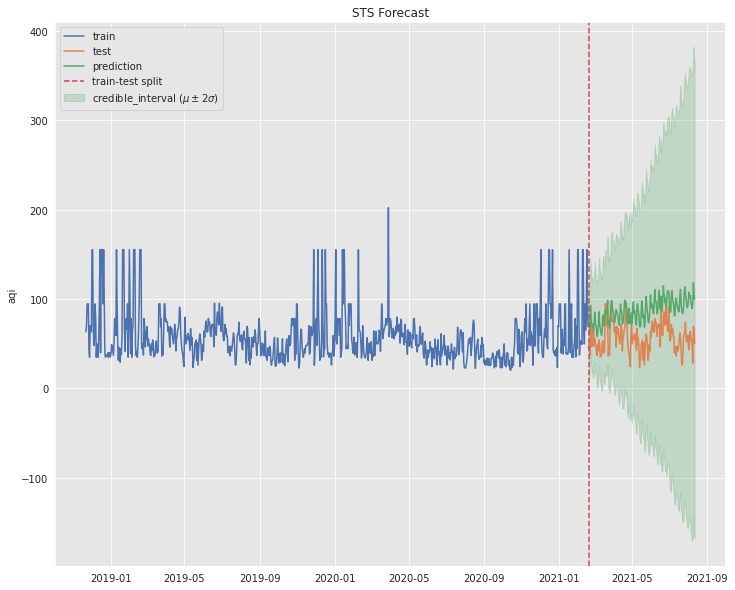

In [32]:
fig, ax = plt.subplots(figsize= (12, 10))

ax.fill_between(
    x=df_test.index,
    y1=df_test['y_pred']-2*df_test['y_pred_std'],
    y2=df_test['y_pred']+2*df_test['y_pred_std'],
    color=sns_c[2], 
    alpha=0.25,
    label=r'credible_interval ($\mu \pm 2\sigma$)'
)

sns.lineplot(x=df_train.index, y='aqi', label='train', data=df_train, ax=ax)
sns.lineplot(x=df_test.index, y='aqi', label='test', data=df_test, ax=ax)
sns.lineplot(x=df_test.index, y='y_pred', label='prediction', data=df_test, ax=ax)
ax.axvline(x= threshold_date, color=sns_c[3], linestyle='--', label='train-test split')
ax.legend(loc='upper left')
ax.set(title='STS Forecast');

# Poznań

In [33]:
df_train, df_test = run_city_prediction(data, strip_accents(CITIES[2]))


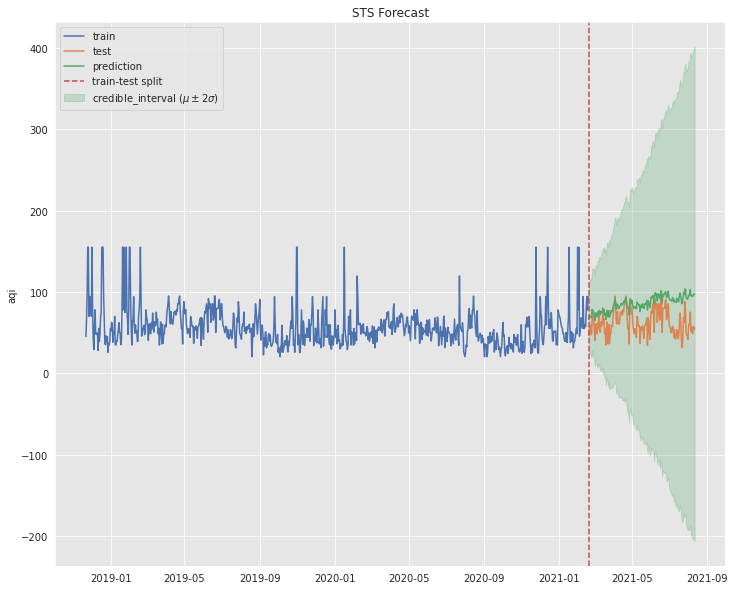

In [34]:
fig, ax = plt.subplots(figsize= (12, 10))

ax.fill_between(
    x=df_test.index,
    y1=df_test['y_pred']-2*df_test['y_pred_std'],
    y2=df_test['y_pred']+2*df_test['y_pred_std'],
    color=sns_c[2], 
    alpha=0.25,
    label=r'credible_interval ($\mu \pm 2\sigma$)'
)

sns.lineplot(x=df_train.index, y='aqi', label='train', data=df_train, ax=ax)
sns.lineplot(x=df_test.index, y='aqi', label='test', data=df_test, ax=ax)
sns.lineplot(x=df_test.index, y='y_pred', label='prediction', data=df_test, ax=ax)
ax.axvline(x= threshold_date, color=sns_c[3], linestyle='--', label='train-test split')
ax.legend(loc='upper left')
ax.set(title='STS Forecast');

# Katowice

In [35]:
df_train, df_test = run_city_prediction(data, strip_accents(CITIES[3]))


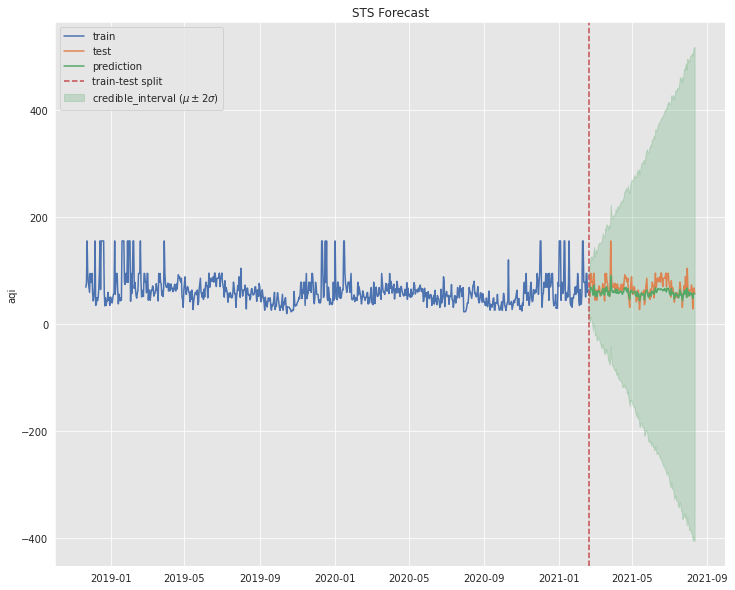

In [36]:
fig, ax = plt.subplots(figsize= (12, 10))

ax.fill_between(
    x=df_test.index,
    y1=df_test['y_pred']-2*df_test['y_pred_std'],
    y2=df_test['y_pred']+2*df_test['y_pred_std'],
    color=sns_c[2], 
    alpha=0.25,
    label=r'credible_interval ($\mu \pm 2\sigma$)'
)

sns.lineplot(x=df_train.index, y='aqi', label='train', data=df_train, ax=ax)
sns.lineplot(x=df_test.index, y='aqi', label='test', data=df_test, ax=ax)
sns.lineplot(x=df_test.index, y='y_pred', label='prediction', data=df_test, ax=ax)
ax.axvline(x= threshold_date, color=sns_c[3], linestyle='--', label='train-test split')
ax.legend(loc='upper left')
ax.set(title='STS Forecast');